In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(12046)

In [2]:
# 一些超参数
context_length = 10
learning_rate = 0.01
eval_iters = 10
batch_size=1000
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
raw_datasets = load_dataset('Nan-Do/code-search-net-python')
datasets = raw_datasets['train'].filter(lambda x: 'apache/spark' in x['repo'])
# 通过索引提取datasets数据的时候，返回一个dict，其中的value是一个字符串
print(datasets[8]['original_string'])
# 当传入的是一个数组时，返回的依然是一个dict，但其中的value是一个列表
print(datasets[8: 10]['original_string'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

(…)-00000-of-00004-ee77a7de79eb2ab2.parquet:   0%|          | 0.00/155M [00:00<?, ?B/s]

(…)-00001-of-00004-648b3bede2edf6e6.parquet:   0%|          | 0.00/139M [00:00<?, ?B/s]

(…)-00002-of-00004-1dfd72b171e6b205.parquet:   0%|          | 0.00/153M [00:00<?, ?B/s]

(…)-00003-of-00004-184ab6d0e3c690b1.parquet:   0%|          | 0.00/151M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/455243 [00:00<?, ? examples/s]

Filter:   0%|          | 0/455243 [00:00<?, ? examples/s]

def to_arrow_schema(schema):
    """ Convert a schema from Spark to Arrow
    """
    import pyarrow as pa
    fields = [pa.field(field.name, to_arrow_type(field.dataType), nullable=field.nullable)
              for field in schema]
    return pa.schema(fields)
['def to_arrow_schema(schema):\n    """ Convert a schema from Spark to Arrow\n    """\n    import pyarrow as pa\n    fields = [pa.field(field.name, to_arrow_type(field.dataType), nullable=field.nullable)\n              for field in schema]\n    return pa.schema(fields)', 'def from_arrow_type(at):\n    """ Convert pyarrow type to Spark data type.\n    """\n    import pyarrow.types as types\n    if types.is_boolean(at):\n        spark_type = BooleanType()\n    elif types.is_int8(at):\n        spark_type = ByteType()\n    elif types.is_int16(at):\n        spark_type = ShortType()\n    elif types.is_int32(at):\n        spark_type = IntegerType()\n    elif types.is_int64(at):\n        spark_type = LongType()\n    elif types.is_float3

In [4]:
# 手动实现tokenizer
class char_tokenizer:

  def __init__(self, data, begin_ind=0, end_ind=1):
        # 数据中出现的所有字符构成字典
        chars = sorted(list(set(''.join(data))))
        # 预留两个位置给开头和结尾的特殊字符
        self.char2ind = {s : i + 2 for i, s in enumerate(chars)}
        self.char2ind['<|b|>'] = begin_ind
        self.char2ind['<|e|>'] = end_ind
        self.begin_ind = begin_ind
        self.end_ind = end_ind
        self.ind2char = {i : s for s, i in self.char2ind.items()}
  # 实现tokenizer的编码器功能
  def encode(self, text):
        '''
        编码
        参数
        ----
        text ：str，文本
        '''
        return [self.char2ind[c] for c in text]

  # 实现tokenizer的解码器功能
  def decode(self, enc):
        '''
        解码
        参数
        ----
        enc ：int or list[int]
        '''
        if isinstance(enc, int):
            return self.ind2char[enc]
        return [self.ind2char[i] for i in enc]


In [5]:
# 举例验证分词器
tok = char_tokenizer(datasets['original_string'])
example_text = 'def postappend(self):'
''.join(tok.decode(tok.encode(example_text))), len(tok.char2ind)

('def postappend(self):', 99)

In [6]:
# 自回归转换，将文本转换成一系列的训练数据
def autoregressive_trans(text, tokenizer, context_length=context_length):
    '''
    将文本转换成一系列的训练数据
    参数
    ----
    text ：str，文本
    tokenizer ：分词器
    context_length ：int，背景文本的长度
    返回
    ----
    inputs ：list[list[int]]，背景文本（特征）
    labels ：list[list[int]]，预测标签
    '''
    inputs, labels = [], []
    b_ind = tokenizer.begin_ind
    e_ind = tokenizer.end_ind
    enc = tokenizer.encode(text)
    # 增加开始和结尾的特殊字符
    x = [b_ind] * context_length + enc + [e_ind]
    for i in range(len(x) - context_length):
        inputs.append(x[i: i + context_length])
        labels.append(x[i + context_length])
    return inputs, labels

In [7]:
# 举例展示自回归模式的训练数据
inputs, labels = autoregressive_trans(example_text, tok)
for a, b in zip(inputs, labels):
  print(''.join(tok.decode(a)), '------>',  tok.decode(b))

<|b|><|b|><|b|><|b|><|b|><|b|><|b|><|b|><|b|><|b|> ------> d
<|b|><|b|><|b|><|b|><|b|><|b|><|b|><|b|><|b|>d ------> e
<|b|><|b|><|b|><|b|><|b|><|b|><|b|><|b|>de ------> f
<|b|><|b|><|b|><|b|><|b|><|b|><|b|>def ------>  
<|b|><|b|><|b|><|b|><|b|><|b|>def  ------> p
<|b|><|b|><|b|><|b|><|b|>def p ------> o
<|b|><|b|><|b|><|b|>def po ------> s
<|b|><|b|><|b|>def pos ------> t
<|b|><|b|>def post ------> a
<|b|>def posta ------> p
def postap ------> p
ef postapp ------> e
f postappe ------> n
 postappen ------> d
postappend ------> (
ostappend( ------> s
stappend(s ------> e
tappend(se ------> l
append(sel ------> f
ppend(self ------> )
pend(self) ------> :
end(self): ------> <|e|>


In [8]:
# 对数据集中的所有数据进行处理
def process(data):
    '''
    在datasets的map里使用，将文本转换成训练数据
    '''
    text = data['original_string']
    # 如果是普通的map操作，传入的值是字符串
    if isinstance(text, str):
        inputs, labels = autoregressive_trans(text, tok)
        return {'inputs': inputs, 'labels': labels}
    # 如果是map操作里面batched=True，传入的值是字符串列表
    inputs, labels = [], []
    for i in text:
        i, l = autoregressive_trans(i, tok)
        inputs += i
        labels += l
    return {'inputs': inputs, 'labels': labels}

In [9]:
# 测试process的功能
process(datasets[8:9])

{'inputs': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 71],
  [0, 0, 0, 0, 0, 0, 0, 0, 71, 72],
  [0, 0, 0, 0, 0, 0, 0, 71, 72, 73],
  [0, 0, 0, 0, 0, 0, 71, 72, 73, 3],
  [0, 0, 0, 0, 0, 71, 72, 73, 3, 87],
  [0, 0, 0, 0, 71, 72, 73, 3, 87, 82],
  [0, 0, 0, 71, 72, 73, 3, 87, 82, 66],
  [0, 0, 71, 72, 73, 3, 87, 82, 66, 68],
  [0, 71, 72, 73, 3, 87, 82, 66, 68, 85],
  [71, 72, 73, 3, 87, 82, 66, 68, 85, 85],
  [72, 73, 3, 87, 82, 66, 68, 85, 85, 82],
  [73, 3, 87, 82, 66, 68, 85, 85, 82, 90],
  [3, 87, 82, 66, 68, 85, 85, 82, 90, 66],
  [87, 82, 66, 68, 85, 85, 82, 90, 66, 86],
  [82, 66, 68, 85, 85, 82, 90, 66, 86, 70],
  [66, 68, 85, 85, 82, 90, 66, 86, 70, 75],
  [68, 85, 85, 82, 90, 66, 86, 70, 75, 72],
  [85, 85, 82, 90, 66, 86, 70, 75, 72, 80],
  [85, 82, 90, 66, 86, 70, 75, 72, 80, 68],
  [82, 90, 66, 86, 70, 75, 72, 80, 68, 11],
  [90, 66, 86, 70, 75, 72, 80, 68, 11, 86],
  [66, 86, 70, 75, 72, 80, 68, 11, 86, 70],
  [86, 70, 75, 72, 80, 68, 11, 86, 70, 75],

In [10]:
# 将数据分为训练集和测试集
tokenized = datasets.train_test_split(test_size=0.1, shuffle=True, seed=1024)
# 将文本转换为训练数据，里面包含inputs和labels
tokenized = tokenized.map(process, batched=True, remove_columns=datasets.column_names)
tokenized.set_format(type='torch', device=device)


Map:   0%|          | 0/615 [00:00<?, ? examples/s]

Map:   0%|          | 0/69 [00:00<?, ? examples/s]

In [11]:
# 构建数据加载器
train_loader = DataLoader(tokenized['train'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tokenized['test'], batch_size=batch_size, shuffle=True)
# 获取一个批量的数据
next(iter(test_loader))


{'inputs': tensor([[66, 66, 89,  ..., 82, 81, 66],
         [88, 80, 69,  ..., 73,  3, 85],
         [76, 80, 72,  ..., 72, 11, 12],
         ...,
         [68, 88, 79,  ..., 88, 70, 72],
         [82, 80, 83,  ..., 76, 82, 81],
         [ 3, 44, 73,  ..., 81, 87,  3]]),
 'labels': tensor([66, 82, 12, 75, 89,  3, 83,  3, 77, 75,  2,  3, 80, 12, 74, 85,  3, 86,
         86, 80,  3, 76, 83,  3, 12,  3,  2,  3, 85, 86, 92,  3, 66, 88, 11, 70,
         70,  3, 21,  3, 82,  3, 89, 76, 85, 15,  3, 80, 72, 14, 82,  3, 85, 11,
         79,  3, 86, 16, 92, 76,  3, 76, 73,  5,  3,  3,  3,  3, 87, 68, 85,  3,
          3, 81, 72, 24, 39, 87, 72,  3, 68, 87,  3, 72, 86, 44,  3, 76,  3, 78,
         73, 85, 80, 76, 58, 12,  2,  3, 87, 68, 82,  3,  3,  3, 85, 62, 81, 81,
         80, 81, 54, 87, 86, 81, 11, 66, 82, 44, 73,  3, 86,  3, 72,  3,  3, 79,
         86, 87,  3,  3, 80, 17, 76,  3, 88, 72, 39, 81, 38, 72, 72, 75, 92, 33,
          3, 37, 80,  3, 76, 81, 85, 85, 81, 72, 85, 71, 88, 16,  3,  

In [12]:
# 定义模型
class CharMLP(nn.Module):
  def __init__(self, vs):
    super().__init__()
    '''
    根据文本背景预测下一个字母是什么
    参数
    ----
    vs ：int，字典大小
    '''
    # 文字嵌入层
    self.embedding= nn.Embedding(vs, 30)
    self.hidden1 = nn.Linear(300, 200)
    self.hidden2 = nn.Linear(200, 100)
    self.out = nn.Linear(100, vs)

  def forward(self, x):
    '''
    向前传播
    参数
    ----
    x ：torch.LongTensor，背景文本，其中的元素表示相应位置的字母在字典中的位置
    返回
    ----
    h ：torch.FloatTensor，预测结果的logits
    '''
    # 因为背景文本的长度（context_length）等于10，
    # 所以x的形状是(B, 10)，B表示批量数据的大小
    B = x.shape[0]           # (B,  10)
    emb = self.embedding(x)      # (B,  10, 30)
    h = emb.view(B, -1)       # (B, 300)
    h = F.relu(self.hidden1(h))    # (B, 200)
    h = F.relu(self.hidden2(h))    # (B, 100)
    h = self.out(h)          # (B,  vs)
    return h



In [13]:
model = CharMLP(len(tok.char2ind)).to(device)

In [14]:
from math import log
@torch.no_grad()
def generate(model, context, max_new_token=300):
  '''
  利用模型生成文本（反复使用模型进行预测）
  参数
  ----
  model ：CharMLP，生成文本的模型
  context ：torch.LongTensor，背景文本，形状为(1, 10)
  max_new_tokens ：int，生成文本的最大长度
  返回
  ----
  out ：list[int]，生成的文本
  '''
  out = []
  # 将模型切换到评估模式
  model.eval()
  for _ in range(max_new_token):
    logits = model(context)
    probs = F.softmax(logits, dim=-1)
    # 根据模型预测的概率，得到最终的预测结果（下一个字母）
    # 这一步运算有一定随机性
    ix = torch.multinomial(probs, num_samples=1)
    # 利用模型的预测结果更新文本背景
    context = torch.cat((context[:, 1:], ix), dim=1)
    out.append(ix.item())
    if ix.item() == tok.end_ind:
      break
  # 将模型切换至训练模式
  model.train()
  return out

In [15]:
# 使用模型来生成文本
context = torch.zeros((1, 10), dtype=torch.long, device=device)
print(''.join(tok.decode(generate(model, context))))

 8,'Z4-n[RN]dA|Z;`Ve{pcYKYnN:RtyG{bdF2o!%xH2R(q2f
}Yp)a=CE/VC"S:<|b|>i0BFWT",;<|b|>R">UZzKGN/PhS#VV)b7go`?`F8e1<|e|>


In [16]:
# 评估模型
@torch.no_grad()
def _loss(model, data_loader):
  loss = []
  data_iter = iter(data_loader)

  # 随机使用多个批量数据来预估模型效果
  for k in range(eval_iters):
    data = next(data_iter, None)
    if data is None:
      data_iter = iter(data_loader)   # 重新创建一个新的 DataLoader 迭代器
      data = next(data_iter, None)    # 再取一个 batch
    inputs, labels = data['inputs'], data['labels']
    logits = model(inputs)
    loss.append(F.cross_entropy(logits, labels).item())
  return torch.tensor(loss).mean().item()


def estimate_loss(model):
  re = {}
  # 将模型切换到评估模式
  model.eval()
  re['train'] = _loss(model, train_loader)
  re['test'] = _loss(model, test_loader)
  # 将模型切换至训练模式
  model.train()
  return re



In [17]:
estimate_loss(model)

{'train': 4.595471382141113, 'test': 4.596110820770264}

In [21]:
def train_mlp(model, optimizer, data_loader, epochs=10):
  # 记录模型在训练集上的模型损失
  lossi = []
  for epoch in range(epochs):
    for i, data in enumerate(data_loader, 0):
      inputs, labels = data['inputs'], data['labels']
      optimizer.zero_grad()
      logits = model(inputs)
      loss = F.cross_entropy(logits, labels)
      lossi.append(loss.item())
      loss.backward()
      optimizer.step()
    # 评估模型，并输出结果
    stats = estimate_loss(model)
    train_loss = f'train loss {stats["train"]:.4f}'
    test_loss = f'test loss {stats["test"]:.4f}'
    print(f'epoch {epoch:>2}: {train_loss}, {test_loss}')
  return lossi


In [22]:
l = train_mlp(model, optim.Adam(model.parameters(), lr=learning_rate), train_loader)

epoch  0: train loss 1.2286, test loss 1.4832
epoch  1: train loss 1.1863, test loss 1.4321
epoch  2: train loss 1.1479, test loss 1.4055
epoch  3: train loss 1.1233, test loss 1.3997
epoch  4: train loss 1.1130, test loss 1.4260
epoch  5: train loss 1.0669, test loss 1.3739
epoch  6: train loss 1.0774, test loss 1.3981
epoch  7: train loss 1.0806, test loss 1.3887
epoch  8: train loss 1.0606, test loss 1.4502
epoch  9: train loss 1.0685, test loss 1.4135


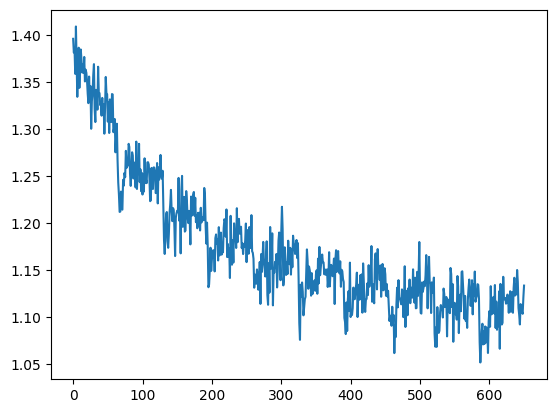

In [24]:
plt.plot(torch.tensor(l).view(-1, 10).mean(1).numpy())

In [27]:
# 使用模型来生成文本
context = torch.zeros((1, 10), dtype=torch.long, device=device)
print(''.join(tok.decode(generate(model, context))))

def dateshfile,
            stats.

        [Row(x) usecend be afted.stream(tdf0):  Row

        >>> stractions
        workDataType(anabes", schema. Ir>Counncimen should be escode(False, -exampleBy` is name eva.
        .__siftpto Stomm-traias an :class:`Init``
        ar'"))
        return sumn ee
